In [1]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.11.0', '1.21.2')

In [2]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "oneshot/Extracted Faces"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [3]:
def split_dataset(directory, split=0.85):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.85)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)


Length of training list: 1125
Length of testing list : 199

Test List: {'290': 2, '313': 3, '665': 2, '1659': 2, '58': 3, '1627': 2, '230': 4, '895': 2, '775': 2, '605': 5, '1027': 3, '1408': 2, '877': 2, '1669': 2, '1610': 6, '630': 2, '1641': 2, '33': 2, '925': 2, '1081': 3, '311': 2, '1143': 2, '942': 2, '670': 3, '778': 2, '700': 10, '1624': 2, '648': 2, '12': 3, '1410': 6, '264': 2, '662': 3, '141': 5, '74': 7, '361': 3, '1254': 7, '1332': 13, '429': 2, '596': 2, '1664': 4, '1628': 2, '617': 2, '207': 3, '637': 18, '83': 20, '719': 25, '1384': 2, '558': 5, '1321': 2, '1670': 2, '473': 7, '1133': 2, '1338': 6, '352': 3, '513': 4, '1383': 2, '1241': 2, '455': 2, '1301': 2, '811': 2, '1298': 4, '1477': 3, '251': 7, '650': 2, '1076': 4, '1125': 2, '94': 2, '476': 3, '563': 2, '1578': 18, '277': 2, '1547': 2, '1074': 4, '435': 7, '742': 4, '1182': 5, '111': 9, '1365': 2, '626': 2, '19': 4, '1337': 5, '1177': 4, '1406': 5, '183': 6, '205': 12, '196': 2, '1205': 7, '770': 2, '1630': 3, '

In [4]:
def create_triplets(directory, folder_list, max_files=15):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [5]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 14073
Number of testing triplets : 2358

Examples of triplets:
(('792', '4.jpg'), ('792', '14.jpg'), ('317', '0.jpg'))
(('727', '2.jpg'), ('727', '3.jpg'), ('1320', '0.jpg'))
(('60', '3.jpg'), ('60', '12.jpg'), ('595', '0.jpg'))
(('60', '2.jpg'), ('60', '11.jpg'), ('882', '1.jpg'))
(('800', '0.jpg'), ('800', '4.jpg'), ('1368', '3.jpg'))


In [6]:
def get_batch(triplet_list, batch_size=512, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

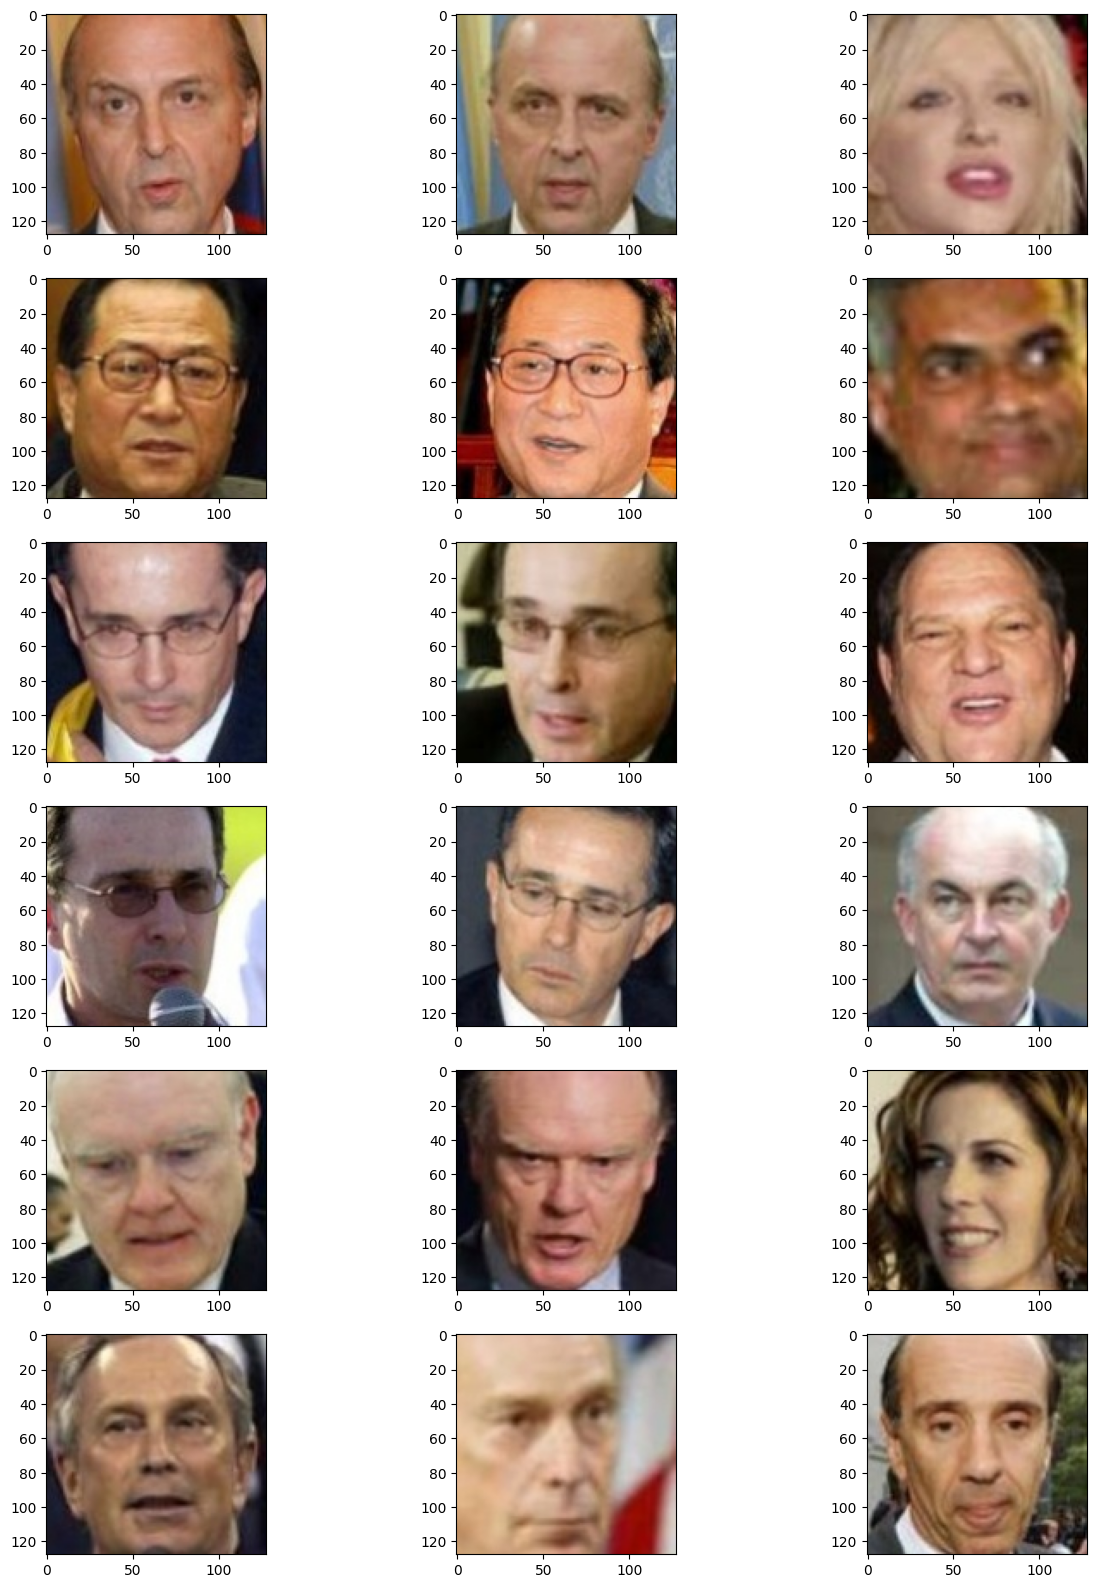

In [7]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [8]:
from tensorflow.keras import backend, layers, metrics
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [28]:
from keras.applications import VGG19

def get_encoder(input_shape, dense_layer_sizes=[1024,512]):
    """ Returns the image encoding model """
    pretrained_model = VGG19(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for layer in pretrained_model.layers[:-4]:
        layer.trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(dense_layer_sizes[0], activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(dense_layer_sizes[1], activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")

    return encode_model


In [29]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape, [1024, 512])
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

In [21]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=0.7):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [22]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [13]:
import tensorflow.keras.backend as K

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [23]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [24]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)


EPOCH: 1 	 (Epoch done in 4169 sec)
Loss on train    = 0.30921
2/2 [==============================] - 15s 6s/step
Accuracy on test = 0.88126

EPOCH: 2 	 (Epoch done in 4168 sec)
Loss on train    = 0.16193
2/2 [==============================] - 13s 6s/step
Accuracy on test = 0.88168

EPOCH: 3 	 (Epoch done in 4022 sec)
Loss on train    = 0.11043
2/2 [==============================] - 15s 6s/step
Accuracy on test = 0.87362

EPOCH: 4 	 (Epoch done in 4152 sec)
Loss on train    = 0.08005
2/2 [==============================] - 16s 8s/step
Accuracy on test = 0.87065

EPOCH: 5 	 (Epoch done in 7223 sec)
Loss on train    = 0.06091
2/2 [==============================] - 17s 7s/step
Accuracy on test = 0.88253

EPOCH: 6 	 (Epoch done in 4015 sec)
Loss on train    = 0.04551
2/2 [==============================] - 14s 6s/step
Accuracy on test = 0.88380

EPOCH: 7 	 (Epoch done in 4142 sec)
Loss on train    = 0.03346
2/2 [==============================] - 13s 5s/step
Accuracy on test = 0.87277

EPOCH

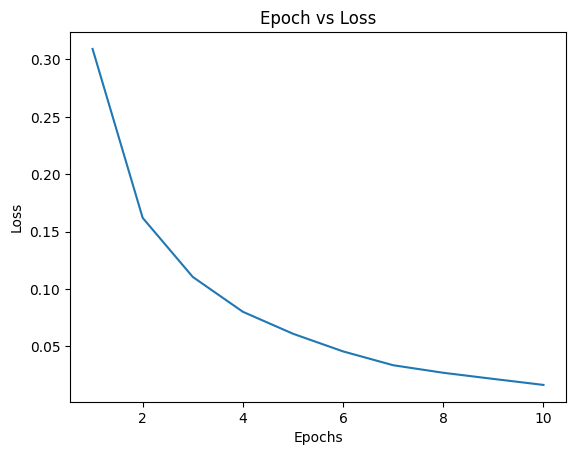

In [18]:
save_all = True
epochs = 10
batch_size = 64  # increase batch size for faster training

max_acc = 0
train_loss = []
test_metrics = []


for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final3")
import matplotlib.pyplot as plt

# your existing code for training and storing the loss values in `train_loss`

# Plotting the epoch vs loss curve
plt.plot(range(1, epochs+1), train_loss)
plt.title('Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [25]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
tf.debugging.set_log_device_placement(True)
tf.debugging.set_log_device_placement(True)


In [26]:

siamese_model.load_weights("siamese_model-final3")

In [30]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 lambda_4 (Lambda)           (None, 512)               0         
                                                      

In [31]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 23s 3s/step

Accuracy of model: 0.802734375



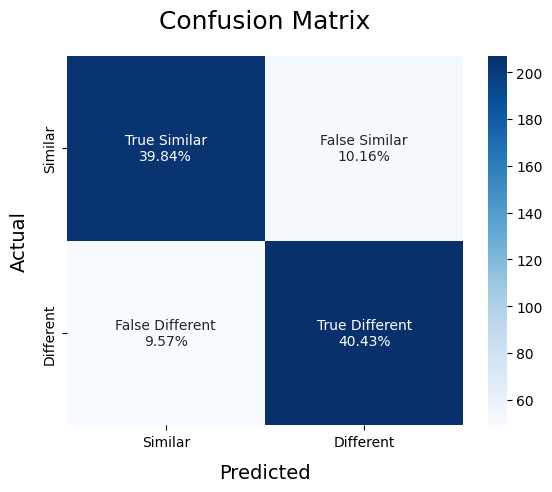

In [32]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [ ]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the data path where the images are stored
data_path = 'oneshot/Extracted Faces'

# Define a list to store the image arrays and a dictionary to store the labels
dataset = []
labels_dict = {}

# Loop through all the subdirectories in the data path and load the images
for i, folder in enumerate(os.listdir(data_path)):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        labels_dict[i] = folder
        for filename in os.listdir(folder_path):
            img = image.load_img(os.path.join(folder_path, filename), target_size=(128, 128))
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = img/255.0
            dataset.append((img, i))

# Define a function to check if a particular image exists in the dataset
def is_image_in_dataset(image_path):
    # Load the test image
    test_image = image.load_img(image_path, target_size=(128, 128))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image/255.0
    
    # Check if the image is in the dataset
    for (img, label) in dataset:
        if np.array_equal(img, test_image):
            print(f"Image {image_path} is in the dataset with label {labels_dict[label]}")
            return True
    
    print(f"Image {image_path} is not in the dataset")
    return False

# Test the function with an example image
is_image_in_dataset('oneshot/Extracted Faces/0/0.jpg')



Image oneshot/Extracted Faces/0/0.jpg is in the dataset with label 0


True

In [ ]:
import time
t= time.time()
is_image_in_dataset('download.jpeg')
duration = time.time()-t
print(f"Time taken to check if the image is in the dataset: {duration:.2f} seconds")

Image download.jpeg is not in the dataset
Time taken to check if the image is in the dataset: 0.29 seconds


In [ ]:

is_image_in_dataset('oneshot/Extracted Faces/4/0.jpg')


Image oneshot/Extracted Faces/4/0.jpg is in the dataset with label 4


True

In [ ]:

import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model


# Define a function to read an image and compute its embedding
def get_image_embedding(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0
    img_embedding = siamese_model.predict(np.expand_dims(img, axis=0))[0]
    return img_embedding

# Define a function to compute the L2 distance between two image embeddings
def compute_distance(embedding1, embedding2):
    diff = embedding1 - embedding2
    dist = np.sqrt(np.sum(np.square(diff)))
    return dist

# Define a function to test if an image exists in the dataset
def test_image_in_dataset(image_path, dataset_embeddings, threshold=0.6):
    # Compute the embedding of the input image
    input_embedding = get_image_embedding(image_path)
    # Compare the input image embedding with each embedding in the dataset
    for key, value in dataset_embeddings.items():
        dist = compute_distance(input_embedding, value)
        if dist < threshold:
            print(f"The input image exists in the dataset as {key[0]}/{key[1]} with distance {dist:.2f}")
            return True
    print("The input image does not exist in the dataset")
    return False

# Load the dataset embeddings
dataset_embeddings = np.load("dataset_embeddings.npy", allow_pickle=True).item()

# Test if an image exists in the dataset
test_image_in_dataset("download.jpeg", dataset_embeddings, threshold=0.6)